# Summary:
* Assign the dataframe schema and column names to play log text files and remove rows with incorrect number of columns in the loading process
* Sanity Check to clean up bad record with invalid play_time and song_length, as well as uids with unreasonably large count of times during the given time frame
* Transform the file_name to proper date format for future feature engineering purpose
* Define the time frame and rules for churn prediction and create the Churn label based on users' activity in the given time frame 
* The work flow of preprocessing for play log files will be used as a template for download and search log files in the next step

In [1]:
import pandas as pd

In [2]:
#sparksession is used to create DF, register DF as tables, excute SQL over tables, cache tables
from pyspark.sql import SparkSession

from pyspark.sql import Row
from pyspark.sql import functions

from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

# from operator import add
# from operator import ge
import sys

In [4]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [3]:
spark = SparkSession.builder.appName("Music Box log clean").getOrCreate()

In [5]:
#load in date file, textFile will return RDD
rdd = sc.textFile("./data/all_play_log.log.fn")

In [31]:
rdd.count()

160158968

In [7]:
rdd.take(10)

['264715 \t 20170302',
 '292363 \t 20170302',
 '154824972 \tar \t3300104 \t0 \tNot A Love Song \tBean \t22 \t178 \t0 \t 20170302',
 '154431666 \tar \t6651913 \t0 \t再见只是陌生人 \t庄心妍 \t252 \t251 \t0 \t 20170302',
 '154439430 \tar \t20870987 \t0 \t哥哥 \t张杰 \t358 \t358 \t0 \t 20170302',
 '154739280 \tar \t872687 \t0 \t苦酒一杯又一杯 \t龙飘飘 \t164 \t165 \t0 \t 20170302',
 '154798546 \tar \t2632638 \t0 \t旋转的潮流 \tDella \t783 \t0 \t0 \t 20170302',
 '154777138 \tip \t9950164 \t0 \t刚好遇见你 \t李玉刚 \t0 \t200 \t0 \t 20170302',
 '154785205 \tar \t502774 \t0 \t阿拉伯之夜 \t群星 \t10 \t0 \t0 \t 20170302',
 '154412619 \tar \t2268011 \t0 \t有一点动心 \t群星 \t235 \t235 \t0 \t 20170302']

### Fix the dataframe schema
after examing the first 10 rows, it's obvious that number of fields in each row can be different. so we cannot do inferschema but should specify the right schema to eliminate the bad rows with fewer columns, and assign column name manually.

In [8]:
#Split each row by "\t", if there are 10 fields with correct type, 
#keep them, if not, skip it, also give the col_name
def parseLine(line):
    fields = line.split("\t")
    if len(fields) == 10:
        try: 
            uid = float(fields[0])
            device = str(fields[1])
            song_id = float(fields[2])
            song_type = float(fields[3])
            song_name = str(fields[4])
            singer = str(fields[5])
            play_time = float(fields[6])
            song_length = float(fields[7])
            paid_flag = float(fields[8])
            file_name = str(fields[9])
            return Row(uid, device, song_id, song_type, song_name, singer, 
                       play_time, song_length, paid_flag, file_name)
        except:
            return Row(None)
    else:
        return Row(None)

# Create Row entries that specify column name, to prepare the RDD to convert it to a DataFrame
# Always important to filter on field length after splitting, to avoid "index out of range error"

In [9]:
# similar to sql table schema setting
# Spark SQL StructType is the data type representing rows. 
# A StructType object comprises a list of StructField, which represents a field in a StructType
# StructField("col_name", dataType, nullable)

schema = StructType([StructField('uid', FloatType(), False),
                     StructField('device', StringType(), True),
                     StructField('song_id', FloatType(), False),
                     StructField('song_type', FloatType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('play_time', FloatType(), False),
                     StructField('song_length', FloatType(), True),
                     StructField('paid_flag', FloatType(), True),
                     StructField('file_name', StringType(), True),])

In [10]:
#filter out the lines with wrong number of columns 
play = rdd.map(parseLine).filter(lambda x: len(x) == len(schema))

In [11]:
#cache means temperorily save in the memory
play_df = spark.createDataFrame(play, schema).cache()

In [12]:
pd.DataFrame(play_df.take(10),columns=play_df.columns)

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,paid_flag,file_name
0,154824976.0,ar,3300104.0,0.0,Not A Love Song,Bean,22.0,178.0,0.0,20170302
1,154431664.0,ar,6651913.0,0.0,再见只是陌生人,庄心妍,252.0,251.0,0.0,20170302
2,154439424.0,ar,20870988.0,0.0,哥哥,张杰,358.0,358.0,0.0,20170302
3,154739280.0,ar,872687.0,0.0,苦酒一杯又一杯,龙飘飘,164.0,165.0,0.0,20170302
4,154798544.0,ar,2632638.0,0.0,旋转的潮流,Della,783.0,0.0,0.0,20170302
5,154777136.0,ip,9950164.0,0.0,刚好遇见你,李玉刚,0.0,200.0,0.0,20170302
6,154785200.0,ar,502774.0,0.0,阿拉伯之夜,群星,10.0,0.0,0.0,20170302
7,154412624.0,ar,2268011.0,0.0,有一点动心,群星,235.0,235.0,0.0,20170302
8,154830960.0,ar,238895.0,0.0,自由飞翔,凤凰传奇,256.0,256.0,0.0,20170302
9,154412736.0,ar,135368.0,0.0,Big Big World,Emilia,206.0,206.0,0.0,20170302


### Clean up the invalid records
* play_time must be shorter or equal to song_length, and both should be positive values
* if play_time is NA, it means the user did not play the song or close the play before it starts. those should be removed

In [13]:
play_df = play_df.filter(play_df.play_time >=0) \
                .filter(play_df.song_length >0) \
                .filter(play_df.play_time<=play_df.song_length)\
                .dropna(how = 'any', subset = ['play_time']).cache()

In [21]:
play_df.select('play_time','song_length').describe().show() #some song_length are very large

+-------+------------------+------------------+
|summary|         play_time|       song_length|
+-------+------------------+------------------+
|  count|         129203197|         129203197|
|   mean|147.25500256529446| 313.0755549752207|
| stddev| 187.4640718975207|174400.39967611732|
|    min|               0.0|               1.0|
|    max|          149983.0|      1.34396621E9|
+-------+------------------+------------------+



In [17]:
#unique uid count
uid_distinct = play_df.select('uid').distinct().count()

In [20]:
print('unique uid in the play file is :{}'.format(uid_distinct) )

unique uid in the play file is :139684


In [22]:
uid_count=play_df.groupBy('uid').count().orderBy('count',ascending= False)

In [23]:
uid_count.show()

+------------+-------+
|         uid|  count|
+------------+-------+
| 3.7025504E7|3128276|
|   1685126.0|3059515|
|   1791497.0|2749957|
|    497685.0|2322327|
|    736305.0|1672403|
|   1062806.0| 767260|
|    751824.0| 556664|
|         0.0| 540872|
| 4.6532272E7| 380882|
| 2.8638488E7| 380439|
|   1749320.0| 375600|
|   1679121.0| 349781|
|    637650.0| 199728|
| 6.4268008E7| 138542|
| 3.2166204E7| 123180|
| 1.5594824E8| 114481|
|1.67982848E8|  81688|
| 2.6036032E7|  80660|
|    533817.0|  70192|
| 1.6517426E7|  65716|
+------------+-------+
only showing top 20 rows



In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
pd_uid_count=uid_count.toPandas()  

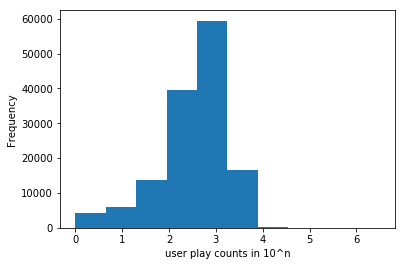

In [80]:
import numpy as np
np.log10(pd_uid_count['count']).plot.hist()
plt.xlabel('user play counts in 10^n')

In [26]:
file_dates=play_df.select('file_name').distinct().orderBy('file_name',ascending= True)
file_dates.head(55)
#20170339 should be 20170329, dates should be fixed/cleaned later. there are missing file dates 20170310-20170328

[Row(file_name=' 20170302'),
 Row(file_name=' 20170303'),
 Row(file_name=' 20170304'),
 Row(file_name=' 20170305'),
 Row(file_name=' 20170306'),
 Row(file_name=' 20170307'),
 Row(file_name=' 20170308'),
 Row(file_name=' 20170309'),
 Row(file_name=' 20170330'),
 Row(file_name=' 20170331'),
 Row(file_name=' 20170339'),
 Row(file_name=' 20170401'),
 Row(file_name=' 20170402'),
 Row(file_name=' 20170403'),
 Row(file_name=' 20170404'),
 Row(file_name=' 20170405'),
 Row(file_name=' 20170406'),
 Row(file_name=' 20170407'),
 Row(file_name=' 20170408'),
 Row(file_name=' 20170409'),
 Row(file_name=' 20170410'),
 Row(file_name=' 20170411'),
 Row(file_name=' 20170412'),
 Row(file_name=' 20170413'),
 Row(file_name=' 20170414'),
 Row(file_name=' 20170415'),
 Row(file_name=' 20170416'),
 Row(file_name=' 20170417'),
 Row(file_name=' 20170418'),
 Row(file_name=' 20170419'),
 Row(file_name=' 20170420'),
 Row(file_name=' 20170421'),
 Row(file_name=' 20170422'),
 Row(file_name=' 20170423'),
 Row(file_name

### Sanity Check: 
file date range is 2017-03-02 to 2017-05-12 minus the missing file dates 2017-03-10 to 2017-03-28 is 53 days. average song length ~4min, a normal user plays at most 10 hours a day, uid count for a day is approx 150 times, so for 53 days, the uid count should be ~ 7950 at most. Those uid that show up more than that boundry can be test or robot account and should be removed from the dataframe.

#### drop uid with extremely large count. those can be robot users

In [27]:
valid_uid=uid_count.filter(uid_count['count']<=7950)

In [29]:
valid_uid.count()

139455

In [30]:
valid_uid.printSchema()

root
 |-- uid: float (nullable = false)
 |-- count: long (nullable = false)



### Join play_df with valid_uid to get all fields of valid uid play history

In [31]:
play_valid_df = play_df.join(valid_uid, on = 'uid', how = 'inner') \
                       .select('uid', 'device', 'song_id', 'play_time', 'song_length', 'file_name') \
                    .cache()

In [32]:
pd.DataFrame(play_valid_df.take(10),columns=play_valid_df.columns)

,uid,device,song_id,play_time,song_length,file_name
0,13586118.0,ar,157799.0,31.0,258.0,20170330
1,13586118.0,ar,9561562.0,6.0,253.0,20170330
2,13586118.0,ar,237843.0,4.0,210.0,20170330
3,13586118.0,ar,9561562.0,0.0,253.0,20170330
4,13586118.0,ar,9561562.0,4.0,253.0,20170330
5,13586118.0,ar,157671.0,1.0,203.0,20170330
6,13586118.0,ar,157671.0,0.0,203.0,20170330
7,13586118.0,ar,157671.0,1.0,203.0,20170330
8,13586118.0,ar,157719.0,237.0,237.0,20170330
9,13586118.0,ar,237843.0,210.0,210.0,20170330


### transform the file_name date string to a proper date format for future feature engineering 

In [33]:
play_valid_df_2=play_valid_df.withColumn('datestring',trim(play_valid_df.file_name.substr(1,9)))\
                             .withColumn('date_val',regexp_replace('datestring','20170339','20170329'))\
                             .withColumn('date_unix',unix_timestamp('date_val','yyyyMMdd'))\
                             .withColumn('date',from_unixtime('date_unix').alias("date").cast(DateType()))

In [36]:
play_valid_df_2.select('date').distinct().show()

+----------+
|      date|
+----------+
|2017-04-09|
|2017-05-11|
|2017-04-25|
|2017-04-03|
|2017-04-29|
|2017-05-10|
|2017-05-09|
|2017-04-07|
|2017-04-02|
|2017-04-12|
|2017-04-11|
|2017-04-05|
|2017-04-20|
|2017-04-27|
|2017-04-18|
|2017-03-05|
|2017-04-30|
|2017-05-05|
|2017-04-15|
|2017-04-26|
+----------+
only showing top 20 rows



In [39]:
play_valid_df_2=play_valid_df_2.drop('date_unix').drop('date_val').drop('datestring')

In [40]:
play_valid_df_2.show()

+-----------+------+---------+---------+-----------+---------+----------+
|        uid|device|  song_id|play_time|song_length|file_name|      date|
+-----------+------+---------+---------+-----------+---------+----------+
|1.3586118E7|    ar| 157799.0|     31.0|      258.0| 20170330|2017-03-30|
|1.3586118E7|    ar|9561562.0|      6.0|      253.0| 20170330|2017-03-30|
|1.3586118E7|    ar| 237843.0|      4.0|      210.0| 20170330|2017-03-30|
|1.3586118E7|    ar|9561562.0|      0.0|      253.0| 20170330|2017-03-30|
|1.3586118E7|    ar|9561562.0|      4.0|      253.0| 20170330|2017-03-30|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0| 20170330|2017-03-30|
|1.3586118E7|    ar| 157671.0|      0.0|      203.0| 20170330|2017-03-30|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0| 20170330|2017-03-30|
|1.3586118E7|    ar| 157719.0|    237.0|      237.0| 20170330|2017-03-30|
|1.3586118E7|    ar| 237843.0|    210.0|      210.0| 20170330|2017-03-30|
|1.3586118E7|    ar|9561562.0|     44.

### Define churn label
* One straightforward way is to use time window to see users' activities. Here we have consecutive files from 2017-03-30 to 2017-05-12(before 03-30 we have 18 days' files unavailable). 
* If we use 2017-03-30 to 2017-04-28 (30 days) as the activity trakcing window and last two weeks 2017-04-29 to 2017-05-12 as the result window to see if a person churns or not - if uid shows up during 2017-04-29 ~ 2017-05-12 then 0(still active) else 1(churned)

In [50]:
window_start_date='2017-04-29'
window_end_date='2017-05-12'
active_uid = play_valid_df_2.filter(play_valid_df_2.date >= '2017-04-29') \
                           .select(play_valid_df_2.uid.alias('active_uid')) \
                           .distinct()

In [42]:
active_uid_count=active_uid.count()
#valid_uid.count() = 139684
active_uid_count

89837

In [47]:
active_uid_count=89837
churn_count=139684-89837
print('churn rate is around {}'.format(churn_count/139684))

churn rate is around 0.35685547378368315


In [51]:
active_uid.printSchema()

root
 |-- active_uid: float (nullable = false)



#### valid uid left join active uid, if there is not a match then the user has churned

In [52]:
uid_label = valid_uid.join(active_uid, valid_uid.uid == active_uid.active_uid, "left_outer")

In [54]:
## spark has a handy function to assign number to null values
uid_label = uid_label.withColumn('Churn', uid_label.active_uid.isNull().astype(IntegerType())).cache()

In [55]:
pd.DataFrame(uid_label.take(10),columns=uid_label.columns)

,uid,count,active_uid,Churn
0,13586118.0,436,NaN,1
1,16844004.0,2,NaN,1
2,22030996.0,185,22030996.0,0
3,23885908.0,42,NaN,1
4,32366964.0,38,NaN,1
5,32962054.0,2,32962054.0,0
6,36249280.0,101,NaN,1
7,39197032.0,6,NaN,1
8,39567468.0,1799,39567468.0,0
9,46055784.0,311,46055784.0,0


In [60]:
## save the dataframe for future use
uid_label.select('uid','Churn').repartition(1).write.csv('valid_uid_label_all',header=True)

In [64]:
uid_label_2=uid_label.drop('count').drop('active_uid')

#### Select the uids that have play records within the tracking window 2017-03-30 to 2017-04-28, remove uid that only show up during 2017-03-02 to 2017-03-09. Since we don't have data from 03-10 to 03-28, it's hard to track those early March uid's activities continuously. Thus exclude that population for now.

In [63]:
select_date_play = play_valid_df_2.filter((play_valid_df_2.date >= '2017-03-30') & \
                                          (play_valid_df_2.date <= '2017-04-28'))\
                                          .cache()

In [66]:
select_play_label=select_date_play.join(uid_label_2, on='uid', how='inner').cache()

In [67]:
select_play_label.show()

+-----------+------+---------+---------+-----------+---------+----------+-----+
|        uid|device|  song_id|play_time|song_length|file_name|      date|Churn|
+-----------+------+---------+---------+-----------+---------+----------+-----+
|1.3586118E7|    ar| 157799.0|     31.0|      258.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar|9561562.0|      6.0|      253.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar| 237843.0|      4.0|      210.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar|9561562.0|      0.0|      253.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar|9561562.0|      4.0|      253.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar| 157671.0|      0.0|      203.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar| 157719.0|    237.0|      237.0| 20170330|2017-03-30|    1|
|1.3586118E7|    ar| 237843.0|    210.0|

In [68]:
select_play_label=select_play_label.drop('file_name')

In [69]:
final_valid_uid=select_play_label.select(countDistinct('uid')).cache()
final_valid_uid.show()

+-------------------+
|count(DISTINCT uid)|
+-------------------+
|             105351|
+-------------------+



In [71]:
select_play_label.filter(select_play_label['Churn']==1).select(countDistinct('uid')).show()

+-------------------+
|count(DISTINCT uid)|
+-------------------+
|              16345|
+-------------------+



In [73]:
print('churn rate within the selected date range is {}'.format(16345/105351))

churn rate within the selected date range is 0.1551480289698247


*
now churn rate drops down from 35% to 15%, which makes sense because a lot of the early March users might have churned(not active anymore) before the 2017-04-28 ~ 2017-05-12 window. So they account for a big portion of the churned users within the time window of interest. Since now that population is excluded from the study, the churn rate drops down significantly.

In [81]:
#save clean play dataframe to csv
select_play_label.repartition(1).write.csv('play_uid_label_1monthWindow',header=True)

In [82]:
valid_uid_1monthWindow=select_play_label.select('uid').distinct()

In [83]:
# save valid uid list in one month window to a separate csv
valid_uid_1monthWindow.repartition(1).write.csv('valid_uid_1monthWindow',header=True)

### Is there any difference in play_time between 0 and 1 churn label?

In [85]:
select_play_label.groupBy('Churn').agg(avg('play_time'),sum('play_time')).show()

+-----+------------------+--------------------+
|Churn|    avg(play_time)|      sum(play_time)|
+-----+------------------+--------------------+
|    1|140.96362608309076| 4.030257202071388E8|
|    0| 145.9039353560695|1.043142739147087...|
+-----+------------------+--------------------+



In [86]:
spark.stop()

### End of Play file Preprocessing